In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.9)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

In [13]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [14]:
fields_ephys = ["name", "vrest", "ri", "sag", "tau"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

##### Filtering shiny

In [15]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [16]:
shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

In [19]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys

INFO:temp_funcs:Read file in as a pandas dataframe


,name,vrest,ri,sag,tau
0,H19.03.306.11.15.02.06,-65.122929,185.124964,0.102990,24.413168
1,H18.06.004.11.02.01,NaN,NaN,NaN,NaN
2,H18.06.004.11.02.03,NaN,NaN,NaN,NaN
3,H18.06.004.11.03.02,NaN,NaN,NaN,NaN
4,H19.06.351.11.15.02.01,-60.251895,561.418355,0.015036,37.969562
...,...,...,...,...,...
1444,H20.06.351.11.06.01.04,-65.023605,242.256120,0.161407,23.458603
1445,H20.06.351.11.06.01.05,-65.133683,246.923044,0.077304,21.062437
1446,H20.06.351.11.06.01.06,-69.985204,311.142892,0.071834,23.771703
1447,H20.06.351.11.06.01.08,-61.401253,309.951991,0.213605,17.061975


##### Human Layer 4 DF

In [20]:
h_l4 = filter_df(shiny_human, "layer", "L4")
h_l4 = create_cond_df(h_l4, "region", ["FCx", "OCx", "PCx", "TCx"]) #473 rows

INFO:temp_funcs:Filtered dataframe based on layer == L4
INFO:temp_funcs:Created a conditional dataframe based on region containing ['FCx', 'OCx', 'PCx', 'TCx']


In [23]:
merged = merge_dataframes(h_l4, ephys, "cell_name", "name", "inner") #379 rows

INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [31]:
merged.dropna(subset=["vrest", "ri", "sag", "tau"], inplace=True) #311 rows

In [32]:
merged

,sample_id,cell_name,roi,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,name,vrest,ri,sag,tau
0,P8S4_180718_354_A01,H18.03.313.11.06.01.05,TCx_L4,0.689,Pass,12.936141,hIVSCC-MET,1.112490,True,Inh L1-2 PAX6 CDH12,1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H18.03.313.11.06.01.05,-63.207101,841.105652,0.147336,57.667624
3,P8S4_190618_356_A01,H19.03.314.12.07.01.01,TCx_L4,0.479,Pass,35.471986,hIVSCC-MET,0.988428,True,Inh L1-4 LAMP5 LCP2 (rosehip),0.984463,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.314.12.07.01.01,-60.490061,265.750021,0.094790,18.017630
4,P1S4_190813_005_A01,H19.03.319.12.07.01.03,TCx_L4,0.616,Pass,17.497605,hIVSCC-MET,1.372332,True,Inh L2-6 LAMP5 CA1 (Igtp),1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.319.12.07.01.03,-66.055191,249.234408,0.056897,15.964836
5,PAS4_190123_453_A01,H19.03.302.11.03.01.03,TCx_L4,0.666,Pass,16.073146,hIVSCC-MET,1.043932,True,Inh L2-6 LAMP5 CA1 (Igtp),0.960779,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.302.11.03.01.03,-59.083222,353.063971,0.022493,16.070204
7,PES4_190311_659_A01,H19.03.306.11.06.02.01,TCx_L4,0.605,Pass,17.100321,hIVSCC-MET,1.401790,True,Inh L2-4 VIP SPAG17,0.518578,GABAergic neuron,VIP,Core,TCx,L4,H19.03.306.11.06.02.01,-63.795358,294.788599,0.204165,21.670489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,PES4_190723_654_A01,H19.03.317.11.10.01.04,TCx_L4,0.486,Fail,6.933865,hIVSCC-MET,0.321862,False,Exc L3-5 RORB ESR1,0.520029,Glutamatergic neuron,IT (L4-6),PoorQ,TCx,L4,H19.03.317.11.10.01.04,-72.970275,199.156299,0.132480,21.685570
373,PES4_190723_656_A01,H19.03.317.11.10.01.06,TCx_L4,0.348,Fail,5.640186,hIVSCC-MET,0.087728,False,Inh L2-4 PVALB WFDC2,0.356891,Glutamatergic neuron,IT (L2-3),PoorQ,TCx,L4,H19.03.317.11.10.01.06,-68.837412,200.062484,0.084629,23.468343
374,PES4_190723_659_A01,H19.03.317.11.10.01.10,TCx_L4,0.742,Pass,24.062907,hIVSCC-MET,0.086580,False,Inh L2-4 PVALB WFDC2,0.561645,GABAergic neuron,VIP,PoorQ,TCx,L4,H19.03.317.11.10.01.10,-66.508256,187.656209,0.086031,25.009076
375,PES4_190723_661_A01,H19.03.317.11.10.01.12,TCx_L4,0.560,Pass,8.214780,hIVSCC-MET,0.111813,False,Inh L2-4 PVALB WFDC2,0.442187,GABAergic neuron,VIP,PoorQ,TCx,L4,H19.03.317.11.10.01.12,-55.004411,263.906240,0.179304,26.764876


In [33]:
region_list = ["FCx", "OCx", "PCx", "TCx"]

d = dict()
for region_name in region_list:
    d[region_name] = filter_df(merged, "region", region_name)
    
#d["FCx"] #31 rows
#d["OCx"] #3 rows
#d["PCx"] #2 rows
#d["TCx"] #275 rows

INFO:temp_funcs:Filtered dataframe based on region == FCx
INFO:temp_funcs:Filtered dataframe based on region == OCx
INFO:temp_funcs:Filtered dataframe based on region == PCx
INFO:temp_funcs:Filtered dataframe based on region == TCx


In [70]:
def proplot(df, col_1, col_2):
    df1 = df[[col_1, col_2]]
    df1["group_count"] = df1.groupby([col_1, col_2])[col_2].transform("count")
    df1["group_total"] = df1.groupby(col_1)[col_2].transform("count")
    df1["proportion"] = (df1["group_count"] / df1["group_total"]) * 100

    proportion_table = pd.pivot_table(df1, values="proportion", index=[col_1], columns=col_2, fill_value=0)
    count_table = pd.pivot_table(df1, values="group_count", index=[col_1], columns=col_2, fill_value=0)
    
    fig_dims = (20, 10)
    f, axes = plt.subplots(figsize=fig_dims)
    
    ax = sns.barplot(x=col_1, y="proportion", data=df1, order=["FCx", "OCx", "PCx", "TCx"],
                 hue=col_2, hue_order=tree_colors, palette=tree_colors)
    ax.set(xlabel="Region", ylabel="Percentage of cell proportion")
    plt.xticks(rotation=0)
    plt.ylim(0, 100)

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

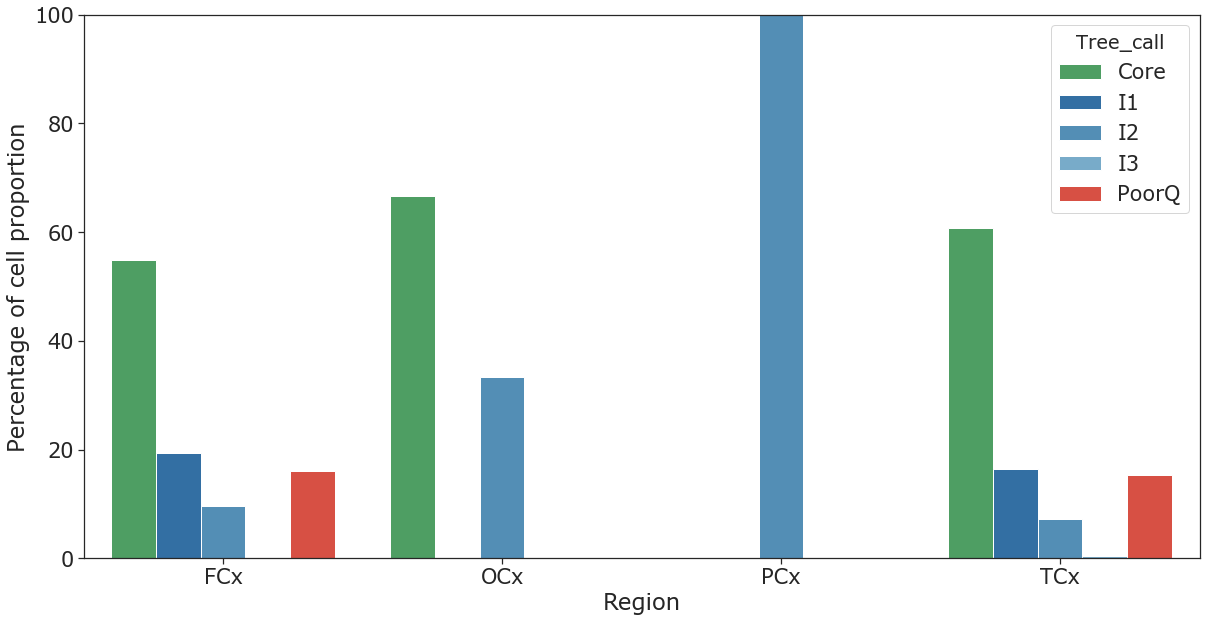

In [71]:
proplot(merged, "region", "Tree_call")

In [56]:
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

In [ ]:
ax = sns.barplot(x="region", y="proportion", data=piv_df, order=["FCx", "OCx", "PCx", "TCx"],
                 hue="Tree_call", hue_order=tree_colors, palette=tree_colors)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

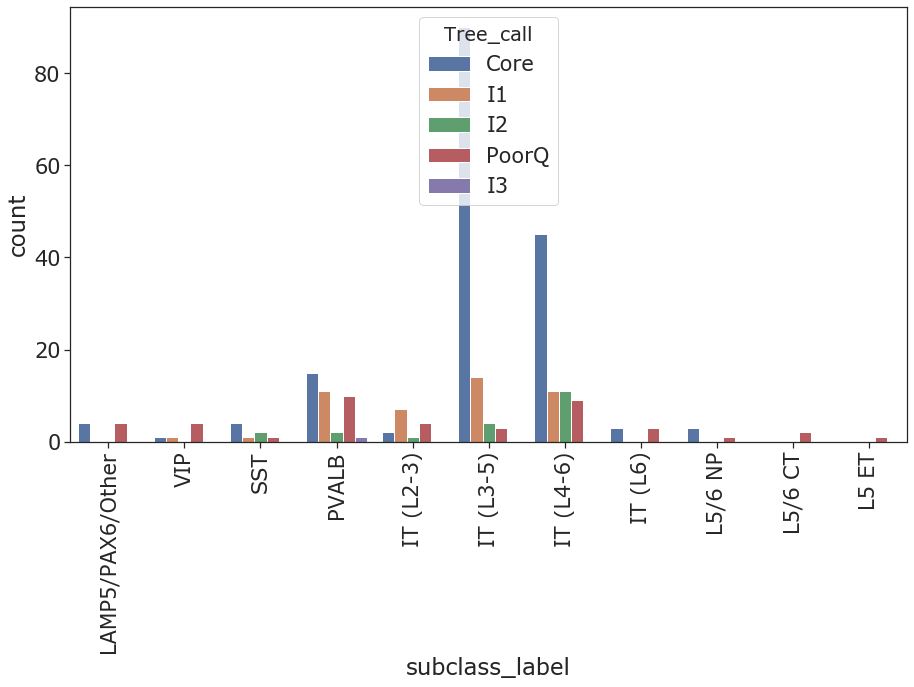

In [52]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=d["TCx"], x="subclass_label", hue="Tree_call")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

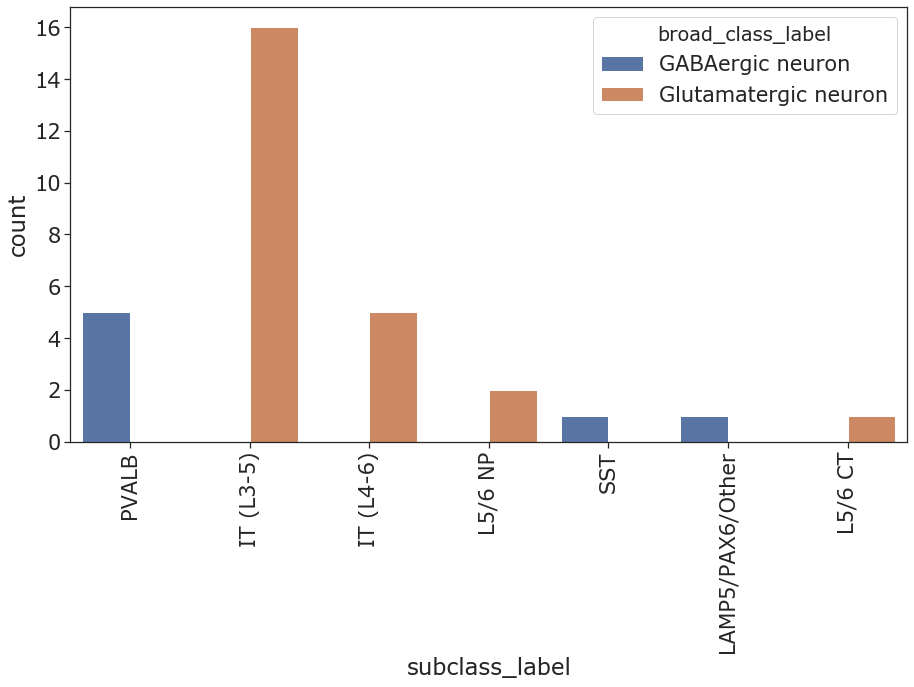

In [46]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=d["FCx"], x="subclass_label", hue="broad_class_label")
plt.xticks(rotation=90)